# Tutorial 5 - Termodinámica avanzada
### Modelación SLE usando PC-SAFT (Thymol + Octanoic acid)

In [1]:
import numpy as np
from epcsaftpy import component, pcsaft
from phasepy import nrtl
import matplotlib.pyplot as plt
from scipy import optimize
import json

**Datos experimentales y parámetros desde la siguiente referencia:**<br />
Tsochantaris, Evangelos, et al. “Evaluating the Performance of the PC-SAFT and CPA Equations of State on Anomalous Properties of Water.” Journal of Chemical & Engineering Data, vol. 65, no. 12, 19 Nov. 2020, pp. 5718–5734, https://doi.org/10.1021/acs.jced.0c00689. 

Liu, Fanghui, et al. “Thermodynamic Investigation of the Effect of Interface Curvature on the Solid–Liquid Equilibrium and Eutectic Point of Binary Mixtures.” The Journal of Physical Chemistry B, vol. 121, no. 40, 29 Sept. 2017, pp. 9452–9462, https://doi.org/10.1021/acs.jpcb.7b07271.

In [2]:
# Inicialización de los compuestos
water = component('water_P3B_1', pure_path = 'parameters/water.json') # 2B = [na = 1,  nb= 1], 3B = [1, 2], 4C = [2, 2]
glycerol = component('glycerol', pure_path = 'parameters/solvents.json')

# Crear el objeto SAFT
mix = glycerol + water
mix.printParameters()

mix.set_kepsijsaft(i = 0, j = 1, kepsij0 = 0.)
saft = pcsaft(mix) #Definición del objeto . nrtl, uniquac ...

# Propiedades calorimétricas
Tm2, dHm2 = 273.15, 6010 # K | J/mol 
Tm1, dHm1 = 291.35, 18300 # K | J/mol 
Tmi = np.array([Tm1, Tm2])
dHmi = np.array([dHm1, dHm2])

component,Mw,$ms$,$\sigma$,$\epsilon / k_B $,"[B, P, N]",$\epsilon _{AB} / k_B$,$k_{AB}$,reference
glycerol,92.09000,2.007,3.8150,430.82,"[0, 1, 1]",4633.5,0.001900,solvents.json
water_P3B_1,18.01528,1.796,2.4697,327.62,"[0, 1, 2]",1558.4,0.068277,water.json


## Funciones objetivo para el SLE
Considerando que las fases sólidas cristalizan independientemente como sólidos puros y despreciando el efecto de la temperatura sobre las capacidades caloríficas, la solubilidad de un sólido en un disolvente líquido se puede describir mediante la siguiente expresión:
$$\ln(x_i \gamma_i^L) = \dfrac{\Delta_m H_i}{R} \left( \dfrac{1}{T_{m,i}} - \dfrac{1}{T} \right) + \dfrac{\Delta_m C_{p,i}}{R} \left( \dfrac{T_{m,i}}{T} - \ln \dfrac{T_{m,i}}{T} - 1 \right)$$

Generalmente, el último término tiene un valor insignificante en comparación con el primero y por lo tanto no se tuvo en cuenta.
$$OF(T) = \dfrac{\Delta_m H_i}{R} \left( \dfrac{1}{T_{m,i}} - \dfrac{1}{T} \right) - \ln(x_i \gamma_i^L) $$ 

In [3]:
R = 8.31446312572960                              # [J mol-1 K-1] Constante gas
# Generamos funciones para resolver el SLE
def fobj_sle(inc, x1, P, index_comp, saft):       
    T = inc[0]
    x = np.array([x1, 1 - x1])
    lngamma = saft.get_lngamma(x, T, P)

    fo = dHmi[index_comp]/R
    fo *= 1/Tmi[index_comp] - 1./T
    fo -= lngamma[index_comp]
    fo -= np.log(x[index_comp])
    
    return fo

# Generamos función para encontrar el punto eutéctico
def fobj_eut(inc, P, saft):                        
    x1, T = inc
    x = np.array([x1, 1 - x1])
    lngamma = saft.get_lngamma(x, T, P)

    fo = dHmi/R
    fo *= 1/Tmi - 1./T
    fo -= lngamma
    fo -= x

    
    return fo

def fobj_sle_ideal(inc, x1, P, index_comp):       
    T = inc[0]
    x = np.array([x1, 1 - x1])
    fo = dHmi[index_comp]/R
    fo *= 1/Tmi[index_comp] - 1./T
    fo -= np.log(x[index_comp])
    
    return fo

def fobj_eut_ideal(inc, P):                        
    x1, T = inc
    x = np.array([x1, 1 - x1])
    fo = dHmi/R
    fo *= 1/Tmi - 1./T
    fo -= np.log(x)

    return fo


### Encontrando el punto eutéctico

In [4]:
P   = 1.01325e5             # Presión [Pa]
X0  = [0.15, 220]         # Valores de inicialización (x0, T0) 
out = optimize.root(fobj_eut, X0, args = (P, saft))
x1eut = out.x[0]
Teut = out.x[1]

out_2 = optimize.root(fobj_eut_ideal, X0, args = P)
x1eut_ideal = out_2.x[0]
Teut_ideal = out_2.x[1]

print("RESULTS")
print("_________________________________")
print("message  :", out.message)
print("success  :", out.success)
print("Composición Eutéctica  x_1E      :", round(x1eut,5))
print("Temperatura Eutéctica T_E [K]   :", round(Teut,3))
print("Composición Eutéctica  x_1E      :", round(x1eut_ideal,5))
print("Temperatura Eutéctica T_E [K]   :", round(Teut_ideal,3))

RESULTS
_________________________________
message  : The solution converged.
success  : True
Composición Eutéctica  x_1E      : 0.51642
Temperatura Eutéctica T_E [K]   : 310.323
Composición Eutéctica  x_1E      : 0.25087
Temperatura Eutéctica T_E [K]   : 246.27


### Calculo del SLE

In [5]:
n = 50
# Calculo desde el componente 2 hasta el punto eutéctico

#Inicialización de variables
T0 = Tmi[1] # Temperatura de fusión del compuesto 2
x1A = np.linspace(0., x1eut, n) # Vector de composciones (fracción molar) desde 0 hasta el punto eutec
TA = np.zeros_like(x1A)
gamm1A = np.zeros_like(x1A)
gamm2A = np.zeros_like(x1A)

x1A_ideal = np.linspace(0., x1eut_ideal, n)
TA_ideal = np.zeros_like(x1A)
x1B_ideal = np.linspace(x1eut_ideal, 1., n)
TB_ideal = np.zeros_like(x1A)

#Loop de calculo ideal
for i in range(n):
    out_2 = optimize.root(fobj_sle_ideal, T0, args = (x1A_ideal[i], P, 1)) # 1 es el index del compuesto
    T0_ideal = out_2.x[0]
    TA_ideal[i] = T0_ideal
    out_2 = optimize.root(fobj_sle_ideal, T0, args = (x1B_ideal[i], P, 0))
    T0_ideal = out_2.x[0]
    TB_ideal[i] = T0_ideal
    

T0 = Tmi[1] # Temperatura de fusión del compuesto 2
x1A = np.linspace(0., x1eut, n) # Vector de composciones (fracción molar) desde 0 hasta el punto eutec
TA = np.zeros_like(x1A)
gamm1A = np.zeros_like(x1A)
gamm2A = np.zeros_like(x1A)

#Loop de calculo
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1A[i], P, 1, saft), method='lm')
    T0 = out.x[0]
    TA[i] = T0
    xA = np.array([x1A[i], 1 - x1A[i]])
    lngamma = saft.get_lngamma(xA, T0, P)
    gamm1A[i], gamm2A[i] = np.exp(lngamma)
    
# Calculo desde el punto eutéctico hasta el componente 1 
#Inicialización de variables
x1B = np.linspace(x1eut, 1., n)
TB = np.zeros_like(x1A)
gamm1B = np.zeros_like(x1B)
gamm2B = np.zeros_like(x1B)
#Loop de calculo
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1B[i], P, 0, saft), method='lm') # 0 es el index del compuesto
    T0 = out.x[0]
    TB[i] = T0
    xB = np.array([x1B[i], 1 - x1B[i]])
    lngamma = saft.get_lngamma(xB, T0, P)
    gamm1B[i], gamm2B[i] = np.exp(lngamma)

In [6]:
TAexp = np.array([273.15, 270.6, 267.1, 262.00, 254.78, 247.40, 237.91, 231.75, 230.70, 228.77])           
TBexp = np.array([229.12, 235.65, 244.82, 251.01, 263.02, 272.75, 281.26, 287.29, 291.35])           
x1Aexp = np.array([0, 0.024, 0.051, 0.091, 0.135, 0.178, 0.23, 0.257, 0.261, 0.274])
x1Bexp = np.array([0.296, 0.325, 0.377, 0.427, 0.524, 0.647, 0.798, 0.916, 1])

def fobj_keps(X):
    kepsij0 = X[0]
    mix = glycerol + water
    #mix.set_kijsaft(i = 0, j = 1, kij0 = kij0)
    mix.set_kepsijsaft(i = 0, j = 1, kepsij0 = kepsij0)
    saft = pcsaft(mix)

    
    nA = len(TAexp)
    TAcal = np.zeros_like(TAexp)
    for i in range(nA):
        out = optimize.root(fobj_sle, TAexp[i], args = (x1Aexp[i], P, 1, saft))
        if out.success:
            TAcal[i] = out.x[0]
    errorA = (1 - TAcal/TAexp)
    
    nB = len(TBexp)
    TBcal = np.zeros_like(TBexp)
    for i in range(nB):
        out = optimize.root(fobj_sle, TBexp[i], args = (x1Bexp[i], P, 0, saft))
        if out.success:
            TBcal[i] = out.x[0]
    errorB = (1 - TBcal/TBexp)
    return np.append(errorA, errorB)

def fobj_k(X):
    kij0 = X[0]
    mix = glycerol + water
    mix.set_kijsaft(i = 0, j = 1, kij0 = kij0)
    #mix.set_kepsijsaft(i = 0, j = 1, kepsij0 = kepsij0)
    saft = pcsaft(mix)

    
    nA = len(TAexp)
    TAcal = np.zeros_like(TAexp)
    for i in range(nA):
        out = optimize.root(fobj_sle, TAexp[i], args = (x1Aexp[i], P, 1, saft))
        if out.success:
            TAcal[i] = out.x[0]
    errorA = (1 - TAcal/TAexp)
    
    nB = len(TBexp)
    TBcal = np.zeros_like(TBexp)
    for i in range(nB):
        out = optimize.root(fobj_sle, TBexp[i], args = (x1Bexp[i], P, 0, saft))
        if out.success:
            TBcal[i] = out.x[0]
    errorB = (1 - TBcal/TBexp)
    return np.append(errorA, errorB)

def fobj_kboth(X):
    kepsij0 = X[0]
    kij0 = X[1]
    mix = glycerol + water
    mix.set_kijsaft(i = 0, j = 1, kij0 = kij0)
    mix.set_kepsijsaft(i = 0, j = 1, kepsij0 = kepsij0)
    saft = pcsaft(mix)

    
    nA = len(TAexp)
    TAcal = np.zeros_like(TAexp)
    for i in range(nA):
        out = optimize.root(fobj_sle, TAexp[i], args = (x1Aexp[i], P, 1, saft))
        if out.success:
            TAcal[i] = out.x[0]
    errorA = (1 - TAcal/TAexp)
    
    nB = len(TBexp)
    TBcal = np.zeros_like(TBexp)
    for i in range(nB):
        out = optimize.root(fobj_sle, TBexp[i], args = (x1Bexp[i], P, 0, saft))
        if out.success:
            TBcal[i] = out.x[0]
    errorB = (1 - TBcal/TBexp)
    return np.append(errorA, errorB)

In [7]:
method = 'lm'
out = optimize.least_squares(fobj_keps, 0., method = method)
out

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\epcsaftpy\pcsaft_mixtures\association\association_aux.py:126: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xass = fsolve(fobj_xass, x0=Xass, args=(xj, aux_asso, diagasso),


     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 0.000e+00  5.293e-04 ... -7.027e-04  0.000e+00]
           x: [-4.653e-02]
        cost: 0.0011357017709649243
         jac: [[ 0.000e+00]
               [-1.958e-03]
               ...
               [-2.224e-02]
               [ 0.000e+00]]
        grad: [-1.798e-07]
  optimality: 1.79821375057819e-07
 active_mask: [0]
        nfev: 11
        njev: None

In [8]:
method = 'lm'
out2 = optimize.least_squares(fobj_k, 0., method = method)
out2 

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [-6.661e-16  1.642e-03 ... -1.669e-03  0.000e+00]
           x: [-2.367e-02]
        cost: 0.004139598067669116
         jac: [[ 0.000e+00]
               [-5.360e-02]
               ...
               [-4.439e-03]
               [ 0.000e+00]]
        grad: [-3.115e-08]
  optimality: 3.115440570757172e-08
 active_mask: [0]
        nfev: 7
        njev: None

In [9]:
method = 'lm'
out3 = optimize.least_squares(fobj_kboth, [0., -2.367e-02], method = method)
out3

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 0.000e+00  1.017e-03 ... -8.416e-04  0.000e+00]
           x: [-3.842e-02 -9.417e-03]
        cost: 0.00029162979530168807
         jac: [[ 0.000e+00  0.000e+00]
               [-2.336e-03 -5.363e-02]
               ...
               [-2.240e-02 -4.444e-03]
               [ 0.000e+00  0.000e+00]]
        grad: [ 1.478e-09 -1.780e-07]
  optimality: 1.7795873080901455e-07
 active_mask: [0 0]
        nfev: 16
        njev: None

### Nuevo calculo usando el valor encontrado de keps_ij (k_ij de hydrogen bond)

In [10]:
n = 50
# Calculo desde el componente 2 hasta el punto eutéctico
mix.set_kepsijsaft(i = 0, j = 1, kepsij0 = out.x) # Parámetro de interacción binaria
mix.printParameters()


P   = 1.01325e5             # Presión [Pa]
X0  = [0.15, 220.0]         # Valores de inicialización (x0, T0) 
out = optimize.root(fobj_eut, X0, args = (P, saft), method='lm')
x1eut = 0.27570343848385703
Teut = 227.9799987653559

print("RESULTS")
print("_________________________________")
print("message  :", out.message)
print("success  :", out.success)
print("Composición Eutéctica  x_1E      :", round(x1eut,5))
print("Temperatura Eutéctica T_E [K]   :", round(Teut,3))
#Inicialización de variables
T0 = Tmi[1] 
x1A = np.linspace(0., x1eut, n)
TA = np.zeros_like(x1A)
gamm1A = np.zeros_like(x1A)
gamm2A = np.zeros_like(x1A)

#Loop de calculo
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1A[i], P, 1, saft))
    T0 = out.x[0]
    TA[i] = T0
    xA = np.array([x1A[i], 1 - x1A[i]])
    lngamma = saft.get_lngamma(xA, T0, P)
    gamm1A[i], gamm2A[i] = np.exp(lngamma)
    
# Calculo desde el punto eutéctico hasta el componente 2 
#Inicialización de variables
x1B = np.linspace(x1eut, 1., n)
TB = np.zeros_like(x1A)
gamm1B = np.zeros_like(x1B)
gamm2B = np.zeros_like(x1B)
#Loop de calculo
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1B[i], P, 0, saft))
    T0 = out.x[0]
    TB[i] = T0
    xB = np.array([x1B[i], 1 - x1B[i]])
    lngamma = saft.get_lngamma(xB, T0, P)
    gamm1B[i], gamm2B[i] = np.exp(lngamma)

component,Mw,$ms$,$\sigma$,$\epsilon / k_B $,"[B, P, N]",$\epsilon _{AB} / k_B$,$k_{AB}$,reference
glycerol,92.09000,2.007,3.8150,430.82,"[0, 1, 1]",4633.5,0.001900,solvents.json
water_P3B_1,18.01528,1.796,2.4697,327.62,"[0, 1, 2]",1558.4,0.068277,water.json


RESULTS
_________________________________
message  : The relative error between two consecutive iterates is at most 0.000000
success  : True
Composición Eutéctica  x_1E      : 0.2757
Temperatura Eutéctica T_E [K]   : 227.98


9 9


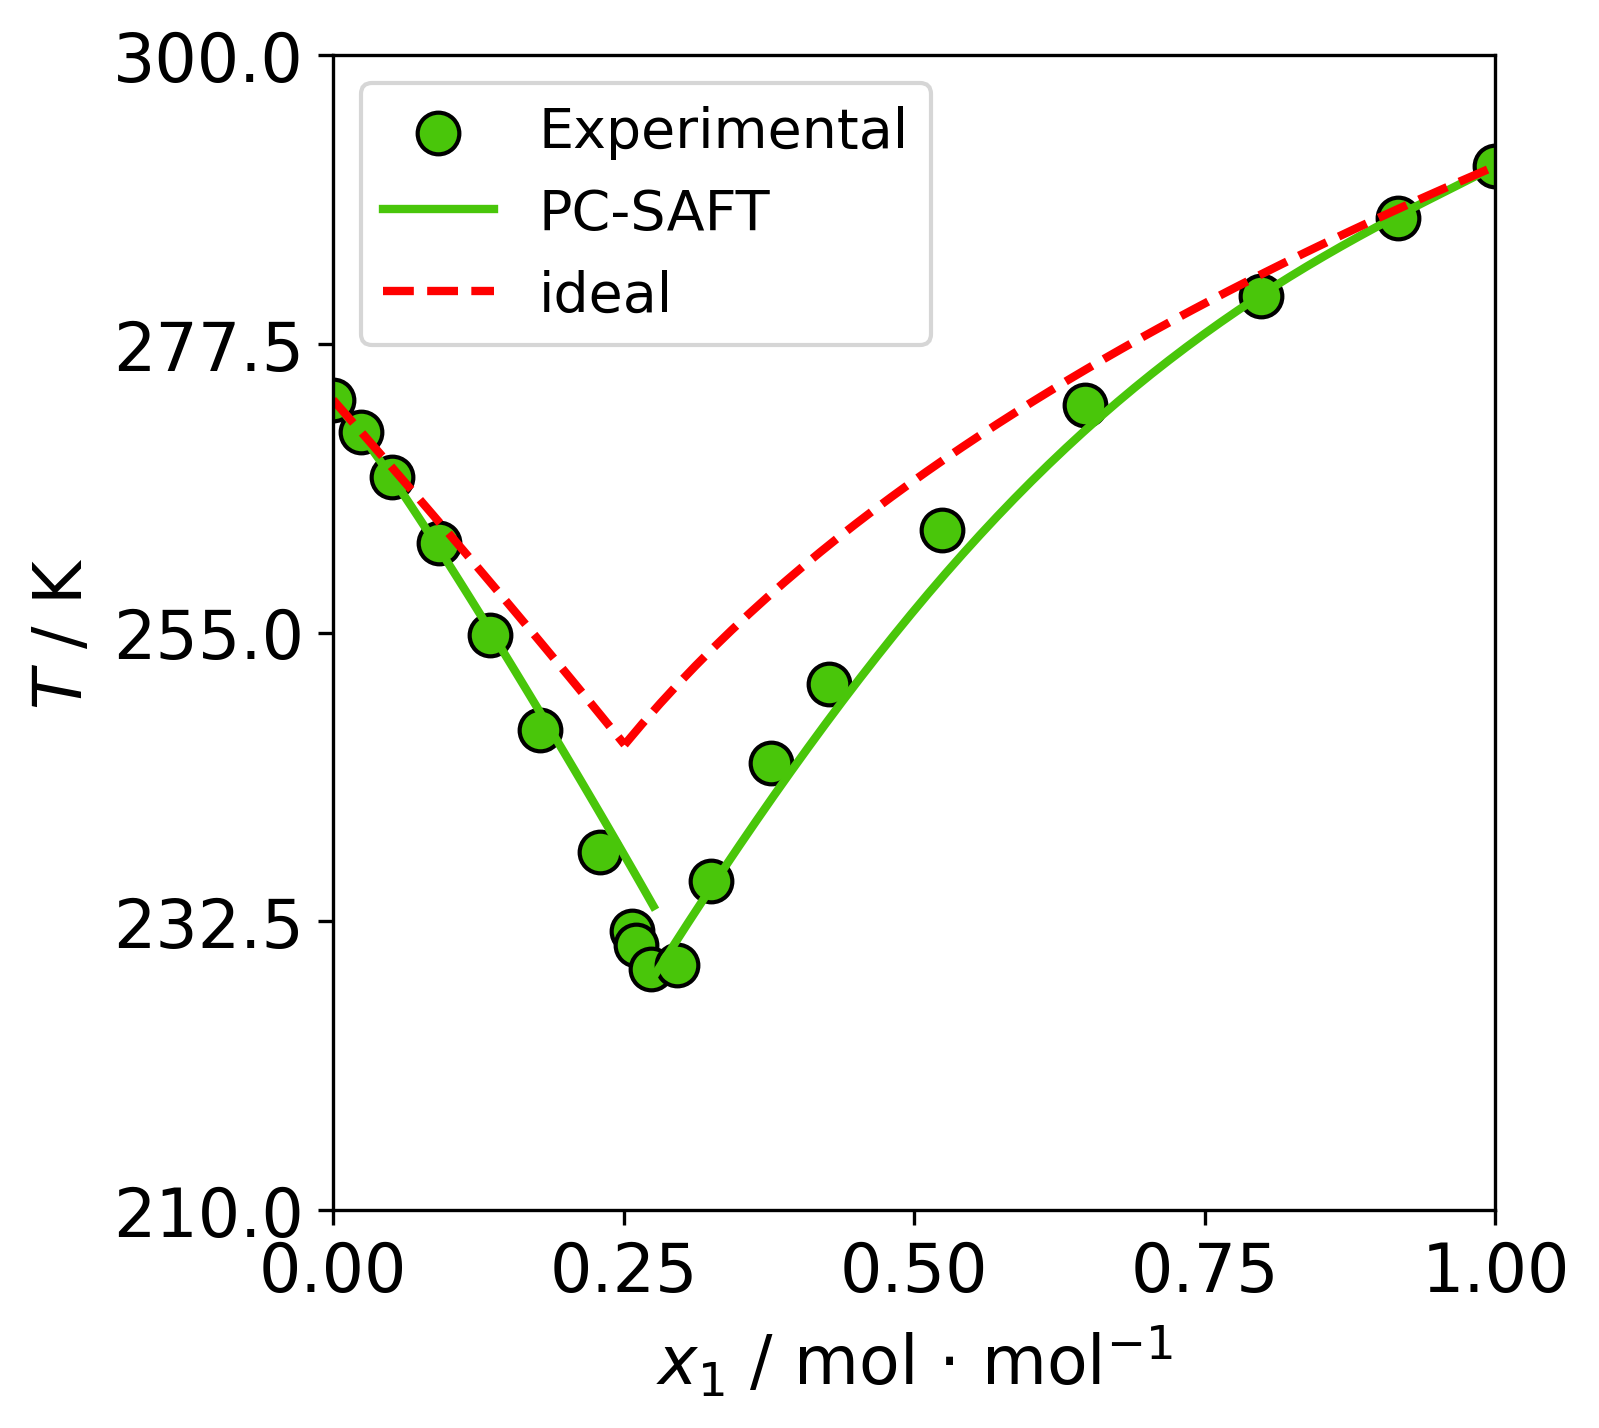

In [11]:
TAexp = np.array([273.15, 270.6, 267.1, 262.00, 254.78, 247.40, 237.91, 231.75, 230.70, 228.77])           
TBexp = np.array([229.12, 235.65, 244.82, 251.01, 263.02, 272.75, 281.26, 287.29, 291.35])           
x1Aexp = np.array([0, 0.024, 0.051, 0.091, 0.135, 0.178, 0.23, 0.257, 0.261, 0.274])
x1Bexp = np.array([0.296, 0.325, 0.377, 0.427, 0.524, 0.647, 0.798, 0.916, 1])
# gammA2exp = np.array([1,0.98, 0.96, 0.86, 0.86, 0.73, 0.68])
# gammB1exp = np.array([0.97, 0.99, 1.02, 1])

print(len(x1Bexp), len(TBexp))

font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

colorSLE = "#49C60A"

fig, ax = plt.subplots(1, figsize=(5, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# ax = axs[0]
ax.scatter(x1Aexp, TAexp, s = 100, c = colorSLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "Experimental")
ax.scatter(x1Bexp, TBexp, s = 100, c = colorSLE, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.plot(x1A, TA, color = colorSLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(x1A_ideal, TA_ideal, color = "red" , 
        linewidth = 2.0, label = "ideal", linestyle='dashed')
ax.plot(x1B, TB, color = colorSLE , 
        linewidth = 2.0)
ax.plot(x1B_ideal, TB_ideal, color = "red" , 
        linewidth = 2.0, linestyle='dashed')

ax.legend(fontsize="small")
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x_1$ / mol $\cdot$ mol$^{-1}$')
ax.axis([0, 1., 210., 300.])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))

plt.show()

### Nuevo calculo usando el valor encontrado de k_ij

In [12]:
n = 50
# Calculo desde el componente 2 hasta el punto eutéctico
mix.set_kijsaft(i = 0, j = 1, kij0 = out2.x) # Parámetro de interacción binaria
mix.printParameters()


P   = 1.01325e5             # Presión [Pa]
X0  = [0.15, 220.0]         # Valores de inicialización (x0, T0) 
out = optimize.root(fobj_eut, X0, args = (P, saft), method='lm')
x1eut = 0.27570343848385703
Teut = 227.9799987653559

print("RESULTS")
print("_________________________________")
print("message  :", out.message)
print("success  :", out.success)
print("Composición Eutéctica  x_1E      :", round(x1eut,5))
print("Temperatura Eutéctica T_E [K]   :", round(Teut,3))
#Inicialización de variables
T0 = Tmi[1] 
x1A = np.linspace(0., x1eut, n)
TA = np.zeros_like(x1A)
gamm1A = np.zeros_like(x1A)
gamm2A = np.zeros_like(x1A)

#Loop de calculo
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1A[i], P, 1, saft))
    T0 = out.x[0]
    TA[i] = T0
    xA = np.array([x1A[i], 1 - x1A[i]])
    lngamma = saft.get_lngamma(xA, T0, P)
    gamm1A[i], gamm2A[i] = np.exp(lngamma)
    
# Calculo desde el punto eutéctico hasta el componente 2 
#Inicialización de variables
x1B = np.linspace(x1eut, 1., n)
TB = np.zeros_like(x1A)
gamm1B = np.zeros_like(x1B)
gamm2B = np.zeros_like(x1B)
#Loop de calculo
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1B[i], P, 0, saft))
    T0 = out.x[0]
    TB[i] = T0
    xB = np.array([x1B[i], 1 - x1B[i]])
    lngamma = saft.get_lngamma(xB, T0, P)
    gamm1B[i], gamm2B[i] = np.exp(lngamma)

component,Mw,$ms$,$\sigma$,$\epsilon / k_B $,"[B, P, N]",$\epsilon _{AB} / k_B$,$k_{AB}$,reference
glycerol,92.09000,2.007,3.8150,430.82,"[0, 1, 1]",4633.5,0.001900,solvents.json
water_P3B_1,18.01528,1.796,2.4697,327.62,"[0, 1, 2]",1558.4,0.068277,water.json


RESULTS
_________________________________
message  : The relative error between two consecutive iterates is at most 0.000000
success  : True
Composición Eutéctica  x_1E      : 0.2757
Temperatura Eutéctica T_E [K]   : 227.98


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\epcsaftpy\pcsaft_mixtures\association\association_aux.py:126: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xass = fsolve(fobj_xass, x0=Xass, args=(xj, aux_asso, diagasso),


9 9


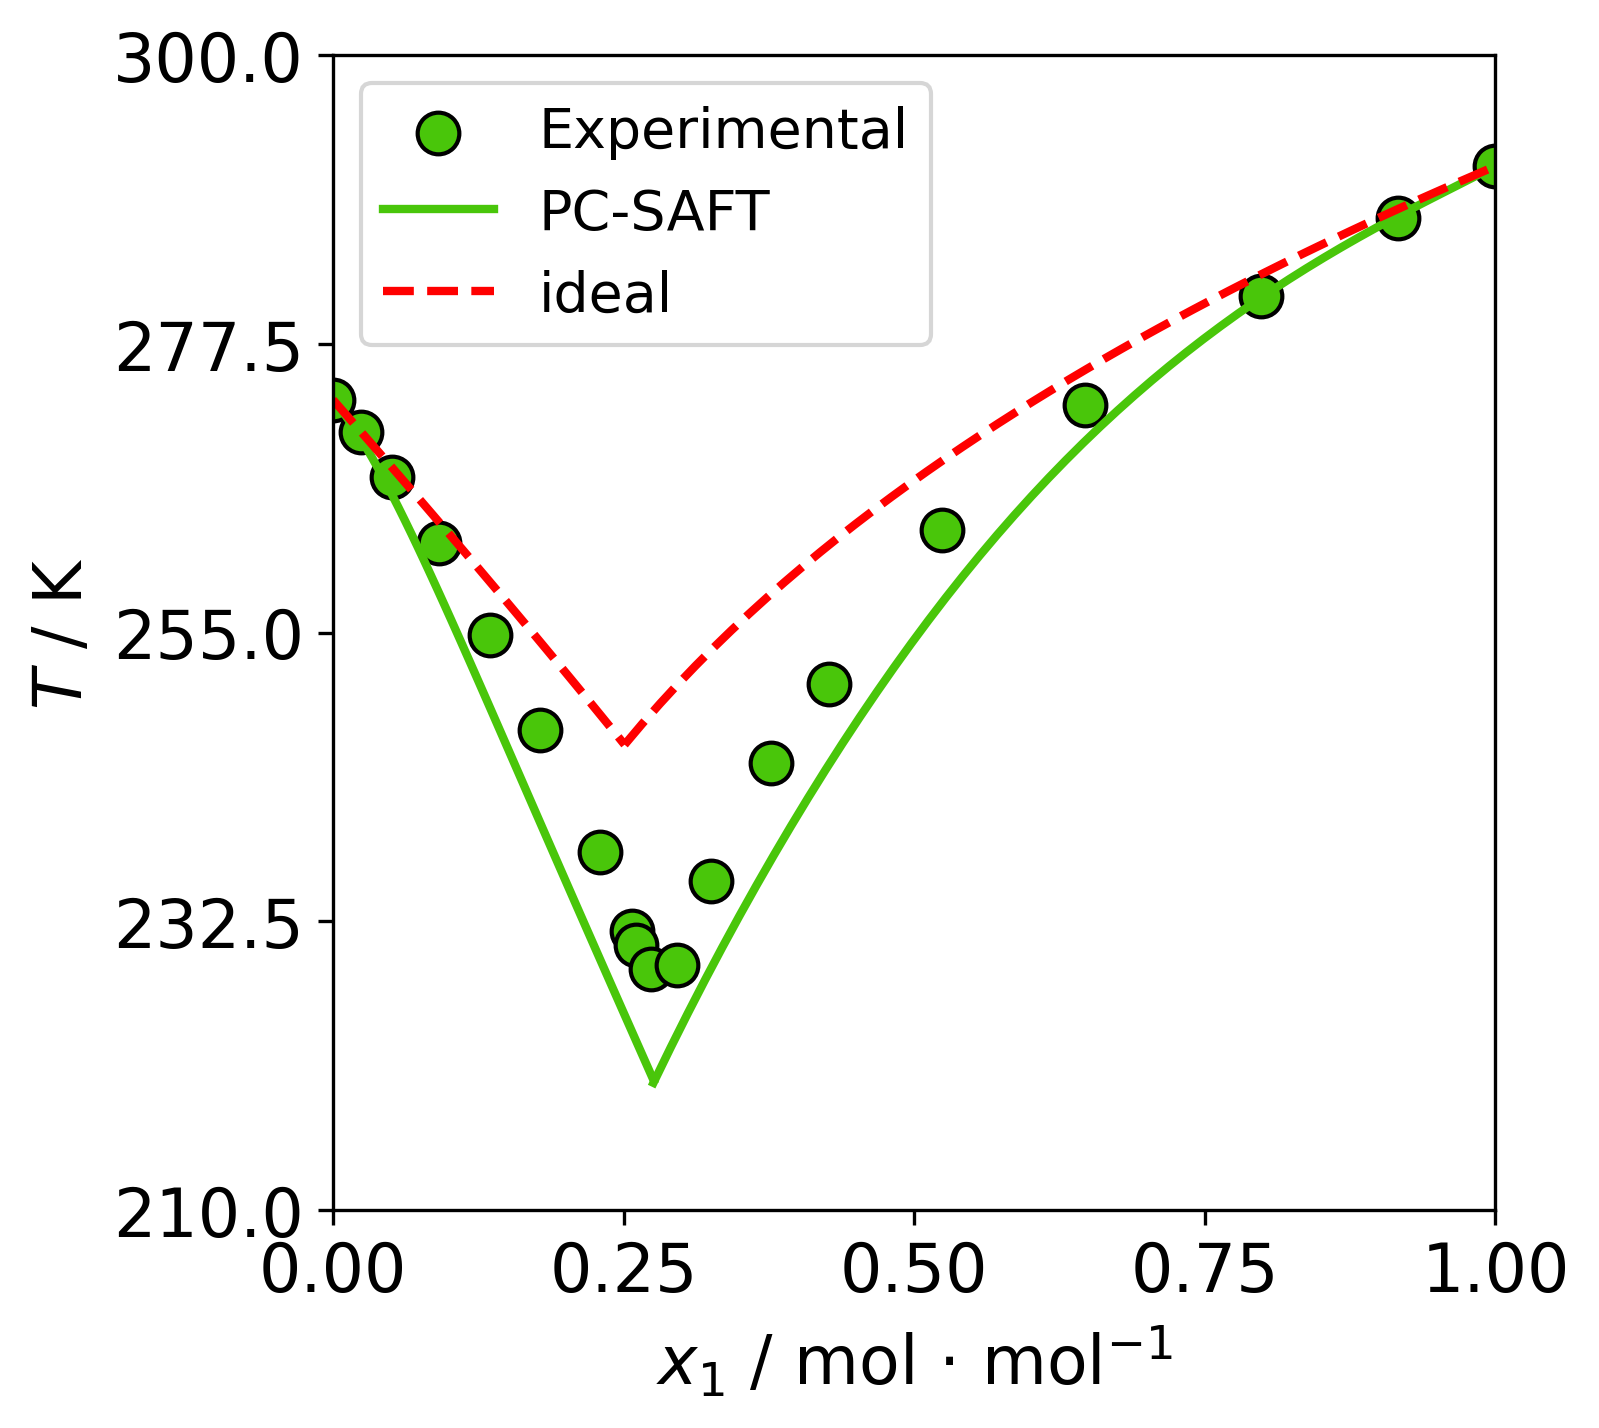

In [13]:
TAexp = np.array([273.15, 270.6, 267.1, 262.00, 254.78, 247.40, 237.91, 231.75, 230.70, 228.77])           
TBexp = np.array([229.12, 235.65, 244.82, 251.01, 263.02, 272.75, 281.26, 287.29, 291.35])           
x1Aexp = np.array([0, 0.024, 0.051, 0.091, 0.135, 0.178, 0.23, 0.257, 0.261, 0.274])
x1Bexp = np.array([0.296, 0.325, 0.377, 0.427, 0.524, 0.647, 0.798, 0.916, 1])
# gammA2exp = np.array([1,0.98, 0.96, 0.86, 0.86, 0.73, 0.68])
# gammB1exp = np.array([0.97, 0.99, 1.02, 1])

print(len(x1Bexp), len(TBexp))

font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

colorSLE = "#49C60A"

fig, ax = plt.subplots(1, figsize=(5, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# ax = axs[0]
ax.scatter(x1Aexp, TAexp, s = 100, c = colorSLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "Experimental")
ax.scatter(x1Bexp, TBexp, s = 100, c = colorSLE, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.plot(x1A, TA, color = colorSLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(x1A_ideal, TA_ideal, color = "red" , 
        linewidth = 2.0, label = "ideal", linestyle='dashed')
ax.plot(x1B, TB, color = colorSLE , 
        linewidth = 2.0)
ax.plot(x1B_ideal, TB_ideal, color = "red" , 
        linewidth = 2.0, linestyle='dashed')

ax.legend(fontsize="small")
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x_1$ / mol $\cdot$ mol$^{-1}$')
ax.axis([0, 1., 210., 300.])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))

plt.show()

### Uso de ambos parámetros

In [14]:
n = 50
# Calculo desde el componente 2 hasta el punto eutéctico
mix.set_kepsijsaft(i = 0, j = 1, kepsij0 = out3.x[0]) # Parámetro de interacción binaria
mix.set_kijsaft(i = 0, j = 1, kij0 = out3.x[1]) # Parámetro de interacción binaria
mix.printParameters()


P   = 1.01325e5             # Presión [Pa]
X0  = [0.15, 220.0]         # Valores de inicialización (x0, T0) 
out = optimize.root(fobj_eut, X0, args = (P, saft), method='lm')
x1eut = 0.27570343848385703
Teut = 227.9799987653559


print("RESULTS")
print("_________________________________")
print("message  :", out.message)
print("success  :", out.success)
print("Composición Eutéctica  x_1E      :", round(x1eut,5))
print("Temperatura Eutéctica T_E [K]   :", round(Teut,3))
#Inicialización de variables
T0 = Tmi[1] 
x1A = np.linspace(0., x1eut, n)
TA = np.zeros_like(x1A)
gamm1A = np.zeros_like(x1A)
gamm2A = np.zeros_like(x1A)

#Loop de calculo
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1A[i], P, 1, saft))
    T0 = out.x[0]
    TA[i] = T0
    xA = np.array([x1A[i], 1 - x1A[i]])
    lngamma = saft.get_lngamma(xA, T0, P)
    gamm1A[i], gamm2A[i] = np.exp(lngamma)
    
# Calculo desde el punto eutéctico hasta el componente 2 
#Inicialización de variables
x1B = np.linspace(x1eut, 1., n)
TB = np.zeros_like(x1A)
gamm1B = np.zeros_like(x1B)
gamm2B = np.zeros_like(x1B)
#Loop de calculo
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1B[i], P, 0, saft))
    T0 = out.x[0]
    TB[i] = T0
    xB = np.array([x1B[i], 1 - x1B[i]])
    lngamma = saft.get_lngamma(xB, T0, P)
    gamm1B[i], gamm2B[i] = np.exp(lngamma)

component,Mw,$ms$,$\sigma$,$\epsilon / k_B $,"[B, P, N]",$\epsilon _{AB} / k_B$,$k_{AB}$,reference
glycerol,92.09000,2.007,3.8150,430.82,"[0, 1, 1]",4633.5,0.001900,solvents.json
water_P3B_1,18.01528,1.796,2.4697,327.62,"[0, 1, 2]",1558.4,0.068277,water.json


RESULTS
_________________________________
message  : The relative error between two consecutive iterates is at most 0.000000
success  : True
Composición Eutéctica  x_1E      : 0.2757
Temperatura Eutéctica T_E [K]   : 227.98


9 9


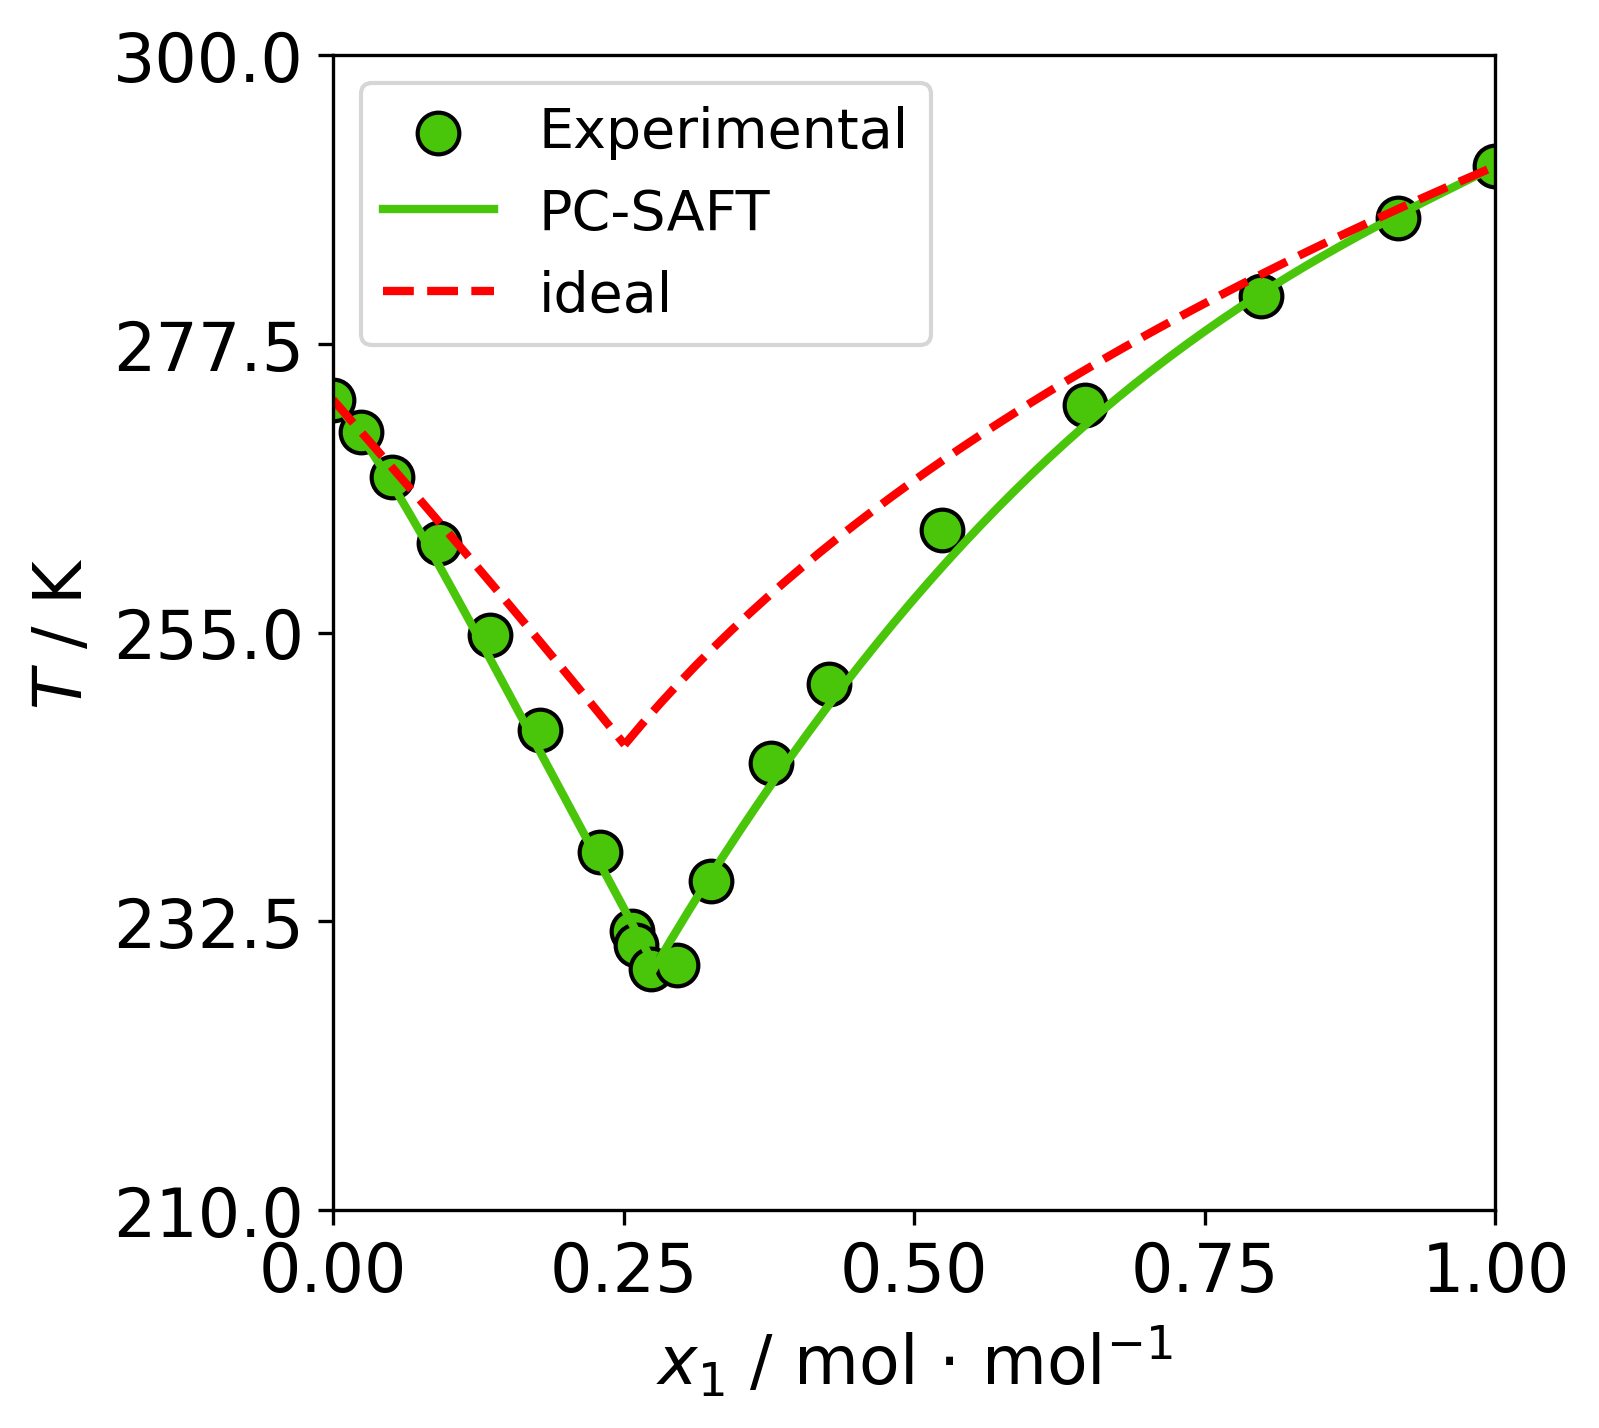

In [15]:
TAexp = np.array([273.15, 270.6, 267.1, 262.00, 254.78, 247.40, 237.91, 231.75, 230.70, 228.77])           
TBexp = np.array([229.12, 235.65, 244.82, 251.01, 263.02, 272.75, 281.26, 287.29, 291.35])           
x1Aexp = np.array([0, 0.024, 0.051, 0.091, 0.135, 0.178, 0.23, 0.257, 0.261, 0.274])
x1Bexp = np.array([0.296, 0.325, 0.377, 0.427, 0.524, 0.647, 0.798, 0.916, 1])
# gammA2exp = np.array([1,0.98, 0.96, 0.86, 0.86, 0.73, 0.68])
# gammB1exp = np.array([0.97, 0.99, 1.02, 1])

print(len(x1Bexp), len(TBexp))

font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

colorSLE = "#49C60A"

fig, ax = plt.subplots(1, figsize=(5, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# ax = axs[0]
ax.scatter(x1Aexp, TAexp, s = 100, c = colorSLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "Experimental")
ax.scatter(x1Bexp, TBexp, s = 100, c = colorSLE, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.plot(x1A, TA, color = colorSLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(x1A_ideal, TA_ideal, color = "red" , 
        linewidth = 2.0, label = "ideal", linestyle='dashed')
ax.plot(x1B, TB, color = colorSLE , 
        linewidth = 2.0)
ax.plot(x1B_ideal, TB_ideal, color = "red" , 
        linewidth = 2.0, linestyle='dashed')

ax.legend(fontsize="small")
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x_1$ / mol $\cdot$ mol$^{-1}$')
ax.axis([0, 1., 210., 300.])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))

plt.show()